### Train ML model using MOM6 data long run

In [1]:
import xarray as xr
import numpy as np 

import jax
from typing import Any, Callable, Sequence
from jax import lax, random, numpy as jnp
#from flax.core import freeze, unfreeze
from flax import linen as nn
from flax.training import train_state 
from flax.training import checkpoints
import flax
flax.config.update('flax_use_orbax_checkpointing', True)

import optax
import xbatcher
import fsspec

#import hvplot.xarray

import matplotlib.pyplot as plt
from datatree import DataTree
from datatree import open_datatree

from datetime import datetime

import xgcm

import sys

sys.path.append('../../modules/')
import helper_func as hf
import ml_helper_func as ml_hf

In [2]:
import os
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']

In [3]:
# initialize for wandb
import wandb
wandb.login()

wandb: Currently logged in as: dhruvbalwada (m2lines). Use `wandb login --relogin` to force relogin


True

In [4]:
#data_bucket = 'gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day/'
data_bucket = f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/'

In [5]:
Lkey = ['50', '100', '200', '400']

res_name = 'all'

ds = {}

for L in Lkey: 
    Lsel = int(L)
    ds_temp = xr.open_zarr(f'{data_bucket}res4km_sponge10day_long_ml_data_'+L+'km.zarr').sel(yh=slice(float(Lsel), 1600-float(Lsel)))
    
    ds[L] = ds_temp 

ds_tree = DataTree.from_dict(ds)

In [6]:
try:
    os.mkdir('figures/'+res_name+'km')
except:
    pass

In [7]:
output_channels = ['Sfnx','Sfny']                                      

input_channels = ['U_x', 'U_y', 
                  'V_x', 'V_y', 
                  #'U_z', 'V_z',
                  'Sx', 'Sy', 'Lfilt']

design_name = 'first_order'

In [8]:
def ML_vars(ds_L, choice=0):
    
    ds_test = xr.Dataset()
    
    ds_test['Sx'] = ds_L.slope_x.isel(zi=1)
    ds_test['Sy'] = ds_L.slope_y.isel(zi=1)
    #ds_test['Lfilt'] = ds_L.h.isel(zl=0)*0. + L
    
    # For the gradients we have some choices to make 
    
    #choice = 0 # 0 thickness weighted, 1 bottom layer, 2 top layer
    # Choose 0, since that is what we are currently using in online sims
    if choice == 0:
        ds_test['U_x'] = (ds_L.dudx * ds_L.h).sum('zl') / ds_L.h.sum('zl')
        ds_test['U_y'] = (ds_L.dudy * ds_L.h).sum('zl') / ds_L.h.sum('zl')
        ds_test['V_x'] = (ds_L.dvdx * ds_L.h).sum('zl') / ds_L.h.sum('zl')
        ds_test['V_y'] = (ds_L.dvdy * ds_L.h).sum('zl') / ds_L.h.sum('zl')
    elif choice ==1: 
        ds_test['U_x'] = ds_L.dudx.isel(zl=1)
        ds_test['U_y'] = ds_L.dudy.isel(zl=1)
        ds_test['V_x'] = ds_L.dvdx.isel(zl=1)
        ds_test['V_y'] = ds_L.dvdy.isel(zl=1)
        
    ds_test['Sfnx'] = ds_L.uh_sg.isel(zl=1)
    ds_test['Sfny'] = ds_L.vh_sg.isel(zl=1)
    
    #ds_test['U_z'] = (ds_L.u.isel(zl=0) - ds_L.u.isel(zl=1))/ ds_L.h.isel(zl=1)
    #ds_test['V_z'] = (ds_L.v.isel(zl=0) - ds_L.v.isel(zl=1))/ ds_L.h.isel(zl=1)
    # ! seems like U_z doesn't really help much
    
    return ds_test

In [9]:
# Create the variables that will be used for the ML 

ds_tree_ML = {}
ds_tree_ML_small = {} # to be used for the sub-sampled data

for L in Lkey: 
    
    # Select dataset 
    ds = ds_tree[L].ds
    
    ds_ML = ML_vars(ds, choice=1)
    
    ds_ML['Lfilt'] = (float(L) + 0*ds_ML.Sx )
    
    ds_tree_ML[L] = ds_ML
    
    sub_samp_fac = int( 400/ int(L) )
    print(sub_samp_fac)
    
    ds_tree_ML_small[L] = ds_ML.isel( xh=slice(0, None, sub_samp_fac), 
                                      yh=slice(0, None, sub_samp_fac) )
    
ds_tree_ML = DataTree.from_dict(ds_tree_ML)
ds_tree_ML_small = DataTree.from_dict(ds_tree_ML_small)

8
4
2
1


In [10]:
ds_train = ds_tree_ML_small.isel(Time=slice(0, 7100))
ds_test  = ds_tree_ML_small.isel(Time=slice(7100, None))

In [11]:
ds_train_stacked = ds_train.stack(points = ['Time','xh','yh'])
ds_test_stacked = ds_test.stack(points = ['Time','xh','yh'])

In [12]:
%%time
ds_train_stacked.load();
ds_test_stacked.load();

CPU times: user 1min 15s, sys: 16.3 s, total: 1min 31s
Wall time: 2min 9s


In [ ]:
equal_data = False
if equal_data:
    ds_train_stacked_equal = {} 

    for L in Lkey: 
        ds = ds_train_stacked[L].ds

        npoints = len(ds['Sfnx']) 

        ds_train_stacked_equal[L] = ds.isel(points=np.random.choice(npoints, size=npoints_400, replace=False))

    ds_train_stacked_equal = DataTree.from_dict(ds_train_stacked_equal)

In [13]:
ds_test_concat = xr.concat([ds_test_stacked['50'].to_dataset(),
                            ds_test_stacked['100'].to_dataset(),
                            ds_test_stacked['200'].to_dataset(),
                            ds_test_stacked['400'].to_dataset()], 
                           dim='points')

ds_train_concat = xr.concat([ds_train_stacked['50'].to_dataset(),
                            ds_train_stacked['100'].to_dataset(),
                            ds_train_stacked['200'].to_dataset(),
                            ds_train_stacked['400'].to_dataset()],
                           dim='points')

In [14]:
%%time 
ds_train_concat.load();
ds_test_concat.load();

CPU times: user 286 µs, sys: 0 ns, total: 286 µs
Wall time: 292 µs


In [15]:
npoints_train = len(ds_train_concat['Sfnx'])
npoints_test = len(ds_test_concat['Sfnx'])
print(npoints_train, npoints_test)

7817100 110100


In [16]:
ds_train_randomized = ds_train_concat.isel(points=np.random.choice(npoints_train, size=npoints_train, replace=False))
ds_test_randomized  = ds_test_concat.isel(points=np.random.choice(npoints_test, size=npoints_test, replace=False))

In [17]:
# norms 
flag_recalc_STD = True 
if flag_recalc_STD:
    try: 
        os.remove('STD_all.nc')
        print('deleted')
    except:
        pass
    
try: 
    ds_norms = xr.open_zarr('./STD_all.nc')
    print('Found all km standard deviations on local')
except:
    print('Not found')
    ds_norms = ds_train_randomized.std()
    ds_norms.compute();
    ds_norms.to_netcdf('./STD_all.nc')

deleted
Not found


In [18]:
ds_train_normalized = (ds_train_randomized / ds_norms)
ds_test_normalized = (ds_test_randomized / ds_norms)

In [19]:
bgen_train = xbatcher.BatchGenerator(ds = ds_train_normalized, 
                               input_dims={},
                               batch_dims={'points': int(npoints_train/30)}   )

bgen_test = xbatcher.BatchGenerator(ds = ds_test_normalized, 
                               input_dims={},
                               batch_dims={'points': int(npoints_test)}   )

In [20]:
len(bgen_train), len(bgen_test)

(30, 1)

### ML model

In [23]:
#size_name = 'small'
#layer_sizes = [24, 24, 2]

size_name = 'medium'
layer_sizes = [32, 32, 2]

#size_name = 'large'
#layer_sizes = [64, 64, 2]


model, params = ml_hf.initialize_model(layer_sizes, len(input_channels), random_key=3 )

In [24]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(params))
print(param_count)

1378


In [25]:
# setup loss function
loss_grad_fn = jax.value_and_grad(ml_hf.mse) # more convenient function as it outputs both value and gradient.

In [26]:
design_name = 'first_order'

In [27]:
# Setup optimizer 

learning_rate = .01 # .05 for 100, .01 for 100, .05 for 100
# Maybe useful if wanting to set learning rates manually: https://github.com/deepmind/optax/issues/4

# Initialize optimizer
tx = optax.adam(learning_rate=learning_rate)

# Define training state 
state = train_state.TrainState.create(
            apply_fn=model.apply, params=params, tx=tx)

In [28]:
num_epochs = 401

In [29]:
run = wandb.init(
    # Set the project where this run will be logged
    project="pointwise_nov_2023_MOM6",
    # Track hyperparameters and run metadata
    name=design_name + ", "+ res_name + ", " + size_name+ ", equal_weights, random_key 3" ,
    config={
        "scale": Lsel,
        "learning_rate": learning_rate,
        "epochs": num_epochs,
        "layer_sizes": layer_sizes,
        "inputs": input_channels, 
        "outputs": output_channels,
        "date": str(datetime.now()),
    })

In [30]:
# to track model
train_loss = np.array([])
test_loss = np.array([])

In [31]:
%%time
# Main training loop


for i in range(num_epochs):
    n=0
    
    loss_temp = np.array([]) # temp array to save batches
    for batch in bgen_train:
        
        #batch = ml_hf.zero_nans(batch, 'uTbyT_z')
        X_train = jnp.asarray(batch[input_channels].to_array().transpose(...,'variable').data)
        y_train = jnp.asarray(batch[output_channels].to_array().transpose(...,'variable').data)
        
        
        # Compute gradients and update parameters and optimizer state 
        loss_val, grads = loss_grad_fn(state.params, state.apply_fn, X_train, y_train)
        state = state.apply_gradients(grads=grads)
        
        loss_temp = np.append(loss_temp, loss_val)
    
    
    train_loss = np.append(train_loss, np.mean(loss_temp))
    
    test_loss_temp = np.array([])
    for batch in bgen_test:
        
        #batch = ml_hf.zero_nans(batch, 'uTbyT_z')
        X_test = jnp.asarray(batch[input_channels].to_array().transpose(...,'variable').data)
        y_test = jnp.asarray(batch[output_channels].to_array().transpose(...,'variable').data)
        
        test_loss_temp = np.append(test_loss_temp, ml_hf.mse(state.params, state.apply_fn, X_test, y_test))
    
    test_loss = np.append(test_loss, np.mean(test_loss_temp))
    
    wandb.log({'train_loss': train_loss[-1], 'test_loss': test_loss[-1]})
    
    if i % 10  == 0:
        print(f'Train loss step {i}: ', train_loss[-1], f'test loss:', test_loss[-1])
        

Train loss step 0:  0.8578453163305918 test loss: 0.6030227541923523
Train loss step 10:  0.2484365224838257 test loss: 0.22662097215652466
Train loss step 20:  0.2349412202835083 test loss: 0.21553491055965424
Train loss step 30:  0.23001069525877635 test loss: 0.2115236520767212
Train loss step 40:  0.22657736539840698 test loss: 0.2091473788022995
Train loss step 50:  0.22420530368884403 test loss: 0.20742347836494446
Train loss step 60:  0.22204043517510097 test loss: 0.205747589468956
Train loss step 70:  0.21979013284047444 test loss: 0.20379717648029327
Train loss step 80:  0.21717076996962228 test loss: 0.20093856751918793
Train loss step 90:  0.21540917754173278 test loss: 0.19929561018943787
Train loss step 100:  0.21419932494560878 test loss: 0.19825106859207153
Train loss step 110:  0.21327276130517323 test loss: 0.19765859842300415
Train loss step 120:  0.21220032026370367 test loss: 0.19653218984603882
Train loss step 130:  0.21143126835425693 test loss: 0.196004718542099

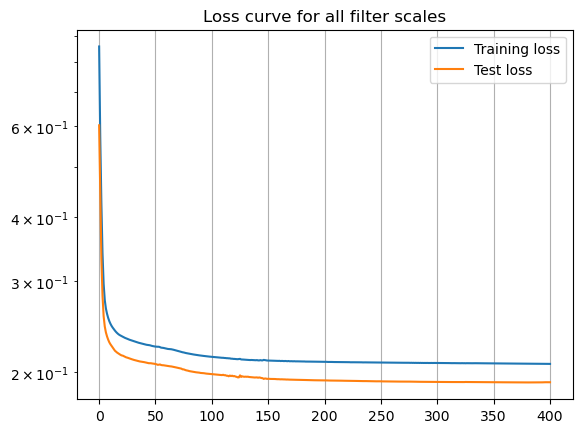

In [32]:
fig, ax = plt.subplots()

ax.plot(train_loss, label='Training loss')
ax.plot(test_loss, label='Test loss')

ax.set_title('Loss curve for all filter scales')
ax.grid()
ax.set_yscale('log')
ax.legend()

fig.savefig('figures/'+res_name+'_km'+'/loss_curve_'+size_name+'random_key3.png')

run.log({"loss_curve": wandb.Image(fig)})

In [33]:
# Save the checkpoint
#CKPT_DIR = 'ckpts_single_all_res_'+size_name
CKPT_DIR = 'ckpts_single_all_res_'+size_name+'_long_sim_random3'
#CKPT_DIR = 'ckpts_single_all_res_'+size_name+'_only_slope'

In [34]:
flax.config.update('flax_use_orbax_checkpointing', False)

In [35]:
checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=state, step=1, overwrite=True)

'ckpts_single_all_res_medium_long_sim_random3/checkpoint_1'

In [36]:
# Read back from the checkpoint
state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)

In [37]:
input_norms = np.zeros((len(input_channels),))

for n, i in enumerate(input_channels):
    #print(i + '=' + str(ds_std[i].values))
    input_norms[n] = ds_norms[i].values
    
output_norms = np.zeros((len(output_channels),))

for n, i in enumerate(output_channels):
    #print(i + '=' + str(ds_std[i].values))
    output_norms[n] = ds_norms[i].values
    
ds_layers = xr.Dataset()

ds_layers['layer_sizes'] = xr.DataArray(np.array([len(input_channels),layer_sizes[0], layer_sizes[1], len(output_channels)]).astype('int32'), dims=['num_layers'])

ds_layers['A0'] = xr.DataArray(np.array(state.params['params']['layers_0']['kernel']).astype('float32'), dims=['input', 'layer1'])
ds_layers['b0'] = xr.DataArray(np.array(state.params['params']['layers_0']['bias']).astype('float32'), dims=['layer1'])

ds_layers['A1'] = xr.DataArray(np.array(state.params['params']['layers_1']['kernel']).astype('float32'), dims=['layer1', 'layer2'])
ds_layers['b1'] = xr.DataArray(np.array(state.params['params']['layers_1']['bias']).astype('float32'), dims=['layer2'])

ds_layers['A2'] = xr.DataArray(np.array(state.params['params']['layers_2']['kernel']).astype('float32'), dims=['layer2', 'output'])
ds_layers['b2'] = xr.DataArray(np.array(state.params['params']['layers_2']['bias']).astype('float32'), dims=['output'])

ds_layers['input_norms'] = xr.DataArray(input_norms.astype('float32'), dims=['input'])
ds_layers['output_norms'] = xr.DataArray(output_norms.astype('float32'), dims=['output'])

In [38]:
ds_layers['layer_sizes'] 

<xarray.DataArray 'layer_sizes' (num_layers: 4)>
array([ 7, 32, 32,  2], dtype=int32)
Dimensions without coordinates: num_layers

In [39]:
#ds_layers.to_netcdf('ann_params_all_res_'+size_name+'.nc', mode='w')
ds_layers.to_netcdf('ann_params_all_res_'+size_name+'_long_random_3.nc', mode='w')

### Check if the model is doing well. 

In [40]:
def R2_score(true, pred, dims = ['xh', 'yh', 'Time']):
    RSS = ((true  - pred)**2).mean(dims)
    TSS = ((true)**2).mean(dims)
    R2 = 1 - RSS/TSS
    return R2 

def corr(true, pred, dims=['xh', 'yh', 'Time']):
    RSS = ((true - true.mean(dims))* (pred - pred.mean(dims))).mean(dims)
    TSS1 = ((true - true.mean(dims))**2).mean(dims)
    TSS2 = ((pred - pred.mean(dims))**2).mean(dims)
   
    corr =  RSS/(TSS1**0.5 * TSS2**0.5)
    return corr

In [41]:
R2_all = np.zeros((4,2))
corr_all = np.zeros((4,2))

for i, L in enumerate(Lkey):
    
    ds_test = ds_tree_ML[L].ds.isel(Time=slice(-100,-1))

    ds_test_normalized = ds_test/ds_norms

    y_pred = state.apply_fn(state.params, 
                            ds_test_normalized[input_channels].to_array().transpose(...,'variable'))

    dims = ds_test[output_channels].to_array().transpose(...,'variable').dims
    coords = ds_test[output_channels].to_array().transpose(...,'variable').coords

    ds_pred = xr.DataArray(y_pred, dims=dims, coords=coords).to_dataset(dim='variable')
    
    R2_all[i,0] = R2_score(ds_test_normalized, ds_pred).Sfnx.values
    R2_all[i,1] = R2_score(ds_test_normalized, ds_pred).Sfny.values
    
    corr_all[i,0] = corr(ds_test_normalized, ds_pred).Sfnx.values
    corr_all[i,1] = corr(ds_test_normalized, ds_pred).Sfny.values

In [42]:
R2_all

array([[0.96055343, 0.95080772],
       [0.94658245, 0.95601284],
       [0.82634353, 0.88075249],
       [0.67292895, 0.79523731]])

In [43]:
corr_all

array([[0.98006191, 0.97966641],
       [0.97204352, 0.97535363],
       [0.903775  , 0.92107227],
       [0.8002275 , 0.74748236]])

/tmp/ipykernel_4015/1866272175.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


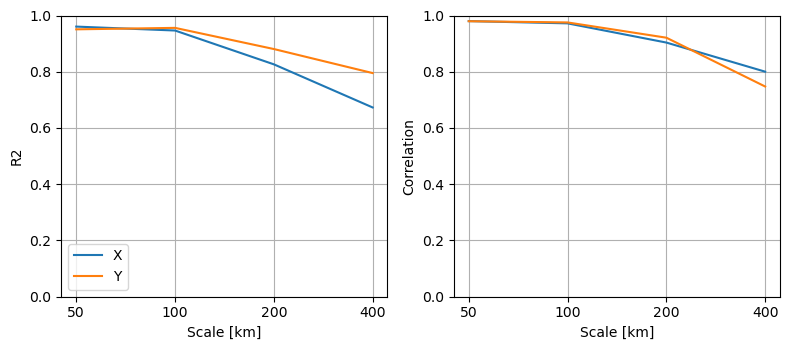

In [44]:
fig = plt.figure(figsize=(8 , 3.6))

plt.subplot(121)
plt.plot(Lkey, R2_all, label=['X', 'Y'])
plt.ylim([0., 1.])
plt.xlabel('Scale [km]')
plt.ylabel('R2')
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(Lkey, corr_all)
plt.ylim([0., 1.])
plt.tight_layout()
plt.xlabel('Scale [km]')
plt.ylabel('Correlation')
plt.grid()

plt.tight_layout()
#run.log({"R2&Corr": wandb.Image(fig)})